In [1]:
from climate_learn.data.climate_dataset import ERA5Args
from climate_learn.data.task import ForecastingArgs
from climate_learn.data.dataset import MapDataset, MapDatasetArgs

/home/prakharsharma/miniconda3/envs/cl_exp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
era_args = ERA5Args(
    "/data0/datasets/weatherbench/data/weatherbench/era5/5.625deg/",
    ["2m_temperature"],
    range(1979, 2015),
)

forecasting_args = ForecastingArgs(
    in_vars = ["era5:2m_temperature"],
    out_vars = ["era5:2m_temperature"],
    constants = [],
    history = 1,
    window = 1,
    pred_range = 1
)

map_dataset_args = MapDatasetArgs(era_args, forecasting_args)
map_dataset = MapDataset(map_dataset_args)

In [3]:
map_dataset.setup()

100%|██████████| 36/36 [00:01<00:00, 18.25it/s]


In [4]:
import torch
apply_transform = 0

In [5]:
constants_data = map_dataset.data.get_constants_data()
const_data = map_dataset.task.create_constants_data(
    constants_data, apply_transform
)
data = []
for index in range(map_dataset.length):
    raw_index = map_dataset.task.get_raw_index(index)
    raw_data = map_dataset.data.get_item(raw_index)
    data.append(map_dataset.task.create_inp_out(raw_data, constants_data, apply_transform))

def handle_dict_features(t) -> torch.tensor:
    ## Hotfix for the models to work with dict style data
    t = torch.stack(tuple(t.values()))
    ## Handles the case for forecasting input as it has history in it
    ## TODO: Come up with an efficient solution instead of if condition
    if len(t.size()) == 4:
        return torch.transpose(t, 0, 1)
    return t

inp: torch.tensor = torch.stack(
    [handle_dict_features(data[i][0]) for i in range(len(data))]
)
out: torch.tensor = torch.stack(
    [handle_dict_features(data[i][1]) for i in range(len(data))]
)
if const_data != {}:
    const: torch.tensor = handle_dict_features(const_data)
else:
    const = None

In [6]:
map_dataset.__len__()

315575

In [7]:
inp.size()

torch.Size([315575, 1, 1, 32, 64])

In [8]:
time_horizon = 7 * 24
window = 1
mean_tensor = []
for i in range(time_horizon, inp.size(0), window):
    mean_tensor.append(torch.mean(inp[i-time_horizon: i], dim=0))
mean_tensor = torch.stack(mean_tensor)

print(mean_tensor.size())

torch.Size([315407, 1, 1, 32, 64])


In [9]:
l_mean_tensor = torch.roll(mean_tensor, 1, -1)
r_mean_tensor = torch.roll(mean_tensor, -1, -1)
d_mean_tensor = torch.roll(mean_tensor, 1, -2)
u_mean_tensor = torch.roll(mean_tensor, -1, -2)

ld_mean_tensor = torch.roll(l_mean_tensor, 1, -2)
lu_mean_tensor = torch.roll(l_mean_tensor, -1, -2)
rd_mean_tensor = torch.roll(r_mean_tensor, 1, -2)
ru_mean_tensor = torch.roll(r_mean_tensor, -1, -2)

g_mean_tensor = 4 * mean_tensor
g_mean_tensor += l_mean_tensor + r_mean_tensor + d_mean_tensor + u_mean_tensor
g_mean_tensor += 0.25 * (ld_mean_tensor + lu_mean_tensor + rd_mean_tensor + ru_mean_tensor)
g_mean_tensor = g_mean_tensor/9


In [10]:

sorted_g_mean_tensor, sorted_args_g_mean_tensor = torch.sort(g_mean_tensor, dim = 0)

In [11]:
low_percentile = 0.05
low_threshold_index = int(low_percentile * g_mean_tensor.size(0))

high_percentile = 0.95
high_threshold_index = int(high_percentile * g_mean_tensor.size(0))

low_threshold = sorted_g_mean_tensor[low_threshold_index]
high_threshold = sorted_g_mean_tensor[high_threshold_index]

In [12]:
low_threshold

tensor([[[[225.4731, 224.9359, 224.3988,  ..., 227.5423, 226.3486, 225.6983],
          [221.4151, 219.5020, 217.8572,  ..., 228.2589, 224.1468, 222.0232],
          [225.5618, 223.4387, 221.6559,  ..., 239.6617, 233.3985, 228.5668],
          ...,
          [263.3662, 264.5631, 263.5764,  ..., 250.1526, 254.3838, 259.5830],
          [250.2723, 250.8328, 250.8501,  ..., 243.1764, 247.3236, 249.2239],
          [243.5655, 243.6640, 243.7087,  ..., 242.6706, 243.3928, 243.5134]]]])

In [13]:
high_threshold

tensor([[[[248.8338, 248.3780, 248.0096,  ..., 250.1181, 249.4744, 249.0987],
          [250.4474, 249.1935, 248.1851,  ..., 255.1564, 252.5500, 251.1537],
          [252.7501, 251.3518, 249.9729,  ..., 262.0346, 257.3403, 254.3721],
          ...,
          [277.4969, 278.4854, 278.8675,  ..., 274.6805, 274.8956, 276.0944],
          [274.3222, 274.6135, 274.7293,  ..., 274.8264, 274.0456, 273.9987],
          [265.3338, 265.2915, 265.2396,  ..., 265.7243, 265.5219, 265.4009]]]])

In [14]:
torch.save(low_threshold, "low_gthreshold.pt")
torch.save(high_threshold, "high_gthreshold.pt")

In [15]:
time = map_dataset.get_time()
time['era5:time'] = time['era5:time'][time_horizon - 1: -1: window]

In [16]:
time['era5:time'].shape

(315407,)

26 45


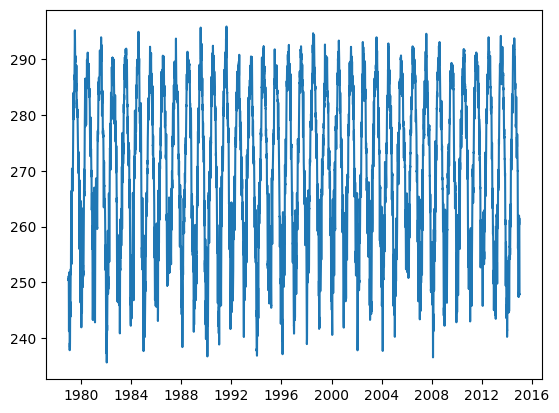

In [20]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

# x = np.array([datetime.datetime(2013, 9, 28, i, 0) for i in range(24)])
# y = np.random.randint(100, size=x.shape)
lat = np.random.randint(0, 31)
lon = np.random.randint(0, 63)
# lat, lon = 0, 0
print(lat, lon)
plt.plot(time['era5:time'], g_mean_tensor[:, 0, 0, lat, lon].numpy())
plt.show()

(array([  136.,   734.,   943.,   885.,  1487.,  2063.,  2500.,  3531.,
         3999.,  4714.,  5357.,  6896.,  7246.,  7495.,  6822.,  7481.,
         7159.,  7952.,  6954.,  7750.,  7731.,  6997.,  6340.,  6202.,
         6799.,  6772.,  5846.,  6624.,  6275.,  7322.,  7015.,  7442.,
         8126.,  8009.,  8228.,  6957.,  6775.,  8572.,  7428.,  8873.,
         9890., 11313., 13834., 13728., 11987.,  9064.,  5548.,  2171.,
         1014.,   421.]),
 array([235.66851807, 236.87149048, 238.07446289, 239.27742004,
        240.48039246, 241.68336487, 242.88633728, 244.08930969,
        245.29226685, 246.49523926, 247.69821167, 248.90118408,
        250.10415649, 251.30711365, 252.51008606, 253.71305847,
        254.91603088, 256.11898804, 257.32196045, 258.52493286,
        259.72790527, 260.93087769, 262.1338501 , 263.33682251,
        264.53979492, 265.74273682, 266.94570923, 268.14868164,
        269.35165405, 270.55462646, 271.75759888, 272.96057129,
        274.1635437 , 275.3665

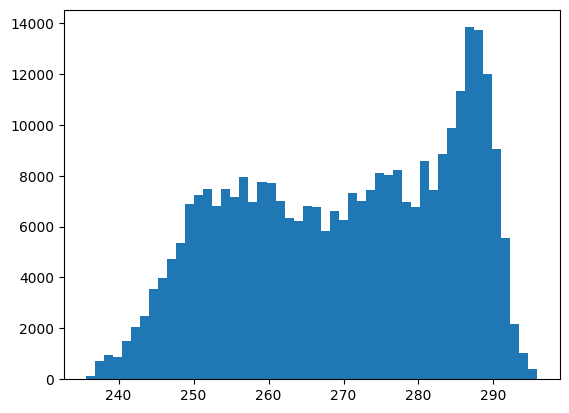

In [21]:
plt.hist(g_mean_tensor[:, 0, 0, lat, lon].numpy(), bins=50)